Import stuff

In [32]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import functions

#pv.set_jupyter_backend("ipyvtklink")

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

Import Envelope Lattice/streetnetwork

In [33]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/meshes/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)
envelope_lattice.shape

env_cens = envelope_lattice.centroids_threshold(-1)

print (env_cens)

# import the streetnetwork as a point cloud (workshop file, temporary)
street_path = os.path.relpath("../data/meshes/street_points.csv")
street_pc = tg.cloud_from_csv(street_path)

print (street_pc)


#importing the context mesh

context_path = os.path.relpath('../data/meshes/immediate_context.obj')
context_mesh = tm.load(context_path)

[[ -40. -100.    0.]
 [ -40. -100.   10.]
 [ -40. -100.   20.]
 ...
 [ 110.  -20.   20.]
 [ 110.  -20.   30.]
 [ 110.  -20.   40.]]
[[ -45. -105.    0.]
 [ -44. -105.    0.]
 [ -43. -105.    0.]
 ...
 [ 120.  -13.    0.]
 [ 120.  -12.    0.]
 [ 120.  -11.    0.]]


Calculate euclidean distance

In [34]:
# extracting the centroid of all voxels
env_cens = envelope_lattice.centroids_threshold(-1)
#print(env_cens.size)
# initializing the distance matrix
dist_m = []
# for each voxel ...
for voxel_cen in env_cens:
    # initializing the distance vector (per each voxel)
    dist_v = []
    # for each street point ...
    for street_point in street_pc:
        # find the difference vector
        diff = voxel_cen - street_point
        # raise the components to the power of two
        diff_p2 = diff**2
        # sum the components
        diff_p2s = diff_p2.sum()
        # compute the square root 
        dist = diff_p2s**0.5
        # add the distance to the distance vector
        dist_v.append(dist)
    # add the distance vector to the distance matrix
    dist_m.append(dist_v)
# change the distance matrix type, from list to array
dist_m = np.array(dist_m)
#print(dist_m.size, dist_m.shape)

# find the distance to the closest street point for each voxel
min_dist = dist_m.min(axis=1)

np_lat = np.array(env_cens)

# convert the minimum distance list to a lattice
min_dist_array = min_dist.reshape(envelope_lattice.shape)
min_dist_lat = tg.to_lattice(min_dist_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_dist_lattice = min_dist_lat * envelope_lattice


Interpolating the euclidean distance to high resolution

In [35]:
lattice_path_highres = os.path.relpath('../data/meshes/voxelized_envelope_highres.csv')
envelope_lattice_highres = tg.lattice_from_csv(lattice_path_highres)

min_dist_lat2 = functions.interpolate(min_dist_lat, envelope_lattice_highres)
envelope_lattice_highres.shape

(31, 18, 8)

Saving the euclidean distance (min_dist_lat)

In [36]:
min_dist_lat2.to_csv('../data/fields/euclidean_distance.csv')

Plotting

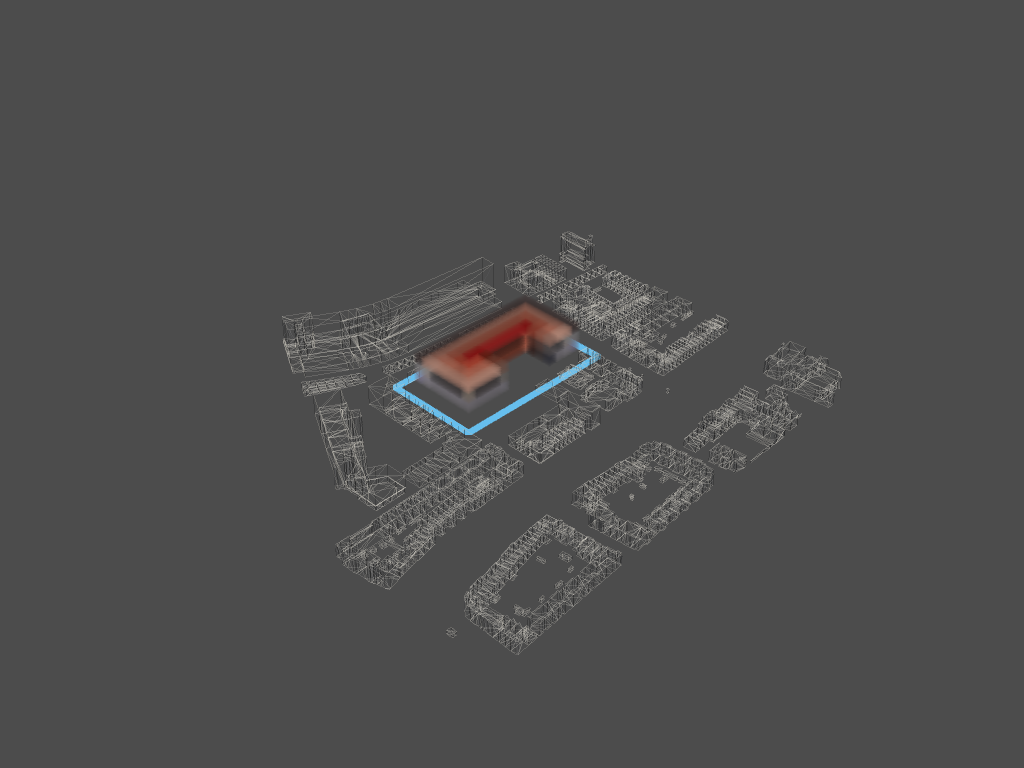

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [37]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_dist_lattice

# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show()


Calculating the actual loudness level

In [38]:
str_loud_lev = 73.4 #dB(a)

#calculating the actual loudness level
# act_loud_lev = ((1 / min_dist_lat) **2) * str_loud_lev

act_loud_lev = str_loud_lev - (10 * (np.log10((2 * np.pi * min_dist_lat) / 2)))

# convert the minimum distance list to a lattice
min_loud_array = act_loud_lev.reshape(envelope_lattice.shape)
min_loud_lat = tg.to_lattice(min_loud_array, envelope_lattice)

# zero the value of the exterior voxels
envelope_eu_loud_lattice = min_loud_lat * envelope_lattice

Plotting the actual loudness level (work in progress)

In [39]:
# initiating the plotter
p = pv.Plotter()

l = min_loud_lat

# remapping
l = (l - l.min()) / (l.max()-l.min())
l=l*envelope_lattice


# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# fast visualization of the point cloud
street_pc.fast_notebook_vis(p)

# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6]) * 1.5
p.add_volume(grid, cmap="coolwarm", opacity=opacity, shade=True, show_scalar_bar=False)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

Inversing the values of the normalized lattice

In [41]:
act_loud_lev_inverse_norm=(1-l)*envelope_lattice

Interpolating the actual loudness level lattices to high resolution

In [45]:

act_loud_lev2 = functions.interpolate(act_loud_lev, envelope_lattice_highres)

act_loud_lev_inverse_norm2 = functions.interpolate(act_loud_lev_inverse_norm, envelope_lattice_highres)
envelope_lattice_highres.shape

(31, 18, 8)

saving the actual loudness level (work in progress)

In [43]:
act_loud_lev2.to_csv('../data/fields/noise_approval.csv')

In [44]:
act_loud_lev_inverse_norm2.to_csv('../data/fields/noise_approval_inverse_norm.csv')